## Libraries

In [2]:
import cProfile
import pstats
import numpy as np
import pandas as pd
from timeit import default_timer as timer
from datetime import timedelta
from matplotlib import pyplot as plt

from smooth_output import smooth_fourier
from Jcb import calc_basis_matrix
from R import calc_penalty_matrix
from cordex_discrete import cordex_discrete
from cordex_continuous import cordex_continuous
from cordex_continuous_v2 import cordex_continuous_v2
from plot_fun import subplot_results
from bayesian_continuous import bo_loop
from Jcb import Jcb
from R import R

# %load_ext autotime

## Settings

In [3]:
runs = 4
levels = np.linspace(-1,1,3).tolist()
epochs = 1_000
optimality = 'A'
method = 'L-BFGS-B'
n_x = [16]
n_b = [3]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])
R_0 = R(*[calc_penalty_matrix(n_b=b) for b in n_b])

## Bayesian Optimization

In [4]:
start = timer()
results, best_cr, _ = bo_loop(epochs=10,
                              runs=runs,
                              f_list=n_x,
                              scalars=scalars,
                              optimality=optimality,
                              initialization_method='L-BFGS-B',
                              J_cb=J_cb,
                              acq_f='A-UCB',
                              beta=0.1,
                              decay_rate=0.9)
end = timer()
print(f"Best criterion {np.round(best_cr,3)} for optimality {optimality}. Execution time (s): {timedelta(seconds=end-start)}")

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: gen_batch_initial_conditions() got an unexpected keyword argument 'fixed_features_list'

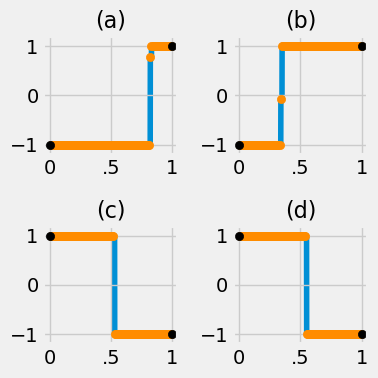

In [10]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0, 1, 1000), results=results)

## Discrete Version

In [45]:
start = timer()
results, best_cr = cordex_discrete(runs=runs,
                                   f_list=n_x,
                                   scalars=scalars,
                                   levels=levels,
                                   epochs=1000,
                                   J_cb=J_cb,
                                   optimality='A',)
end = timer()
print(f"Optimality: {optimality}"
      f"\nBest criterion: {np.round(best_cr,3)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")

100%|██████████| 1000/1000 [01:43<00:00,  9.63it/s]

Optimality: A
Best criterion: 8.624
Execution time (s): 0:01:43.868950


In [46]:
Z = np.concatenate((np.ones((runs,1)), results[:, :sum(n_x)] @ J_cb, results[:, sum(n_x):]), axis=1)
np.trace(np.linalg.inv(Z.T @ Z))

8.62388360781054

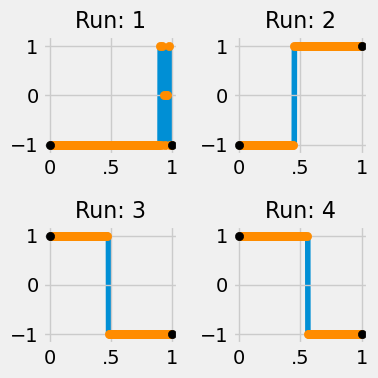

In [47]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0, 1, 1000), results=results[:, :n_x[0]])

## Continuous Version

In [ ]:
 # Nelder-Mead, L-BFGS-B, Powell, TNC
# with cProfile.Profile() as profile:
#     start = timer()
#     results, best_cr = cordex_continuous(runs=runs,
#                                          f_list=n_x,
#                                          scalars=scalars,
#                                          J_cb=J_cb,
#                                          R_0=None,
#                                          epochs=1000,
#                                          method='L-BFGS-B',
#                                          optimality=optimality,
#                                          random_start=False,
#                                          disable_bar=True,
#                                          penalty=0,
#                                          final_pass=False)
#     end = timer()
#     print(f"Optimality: {optimality}"
#           f"\nBest criterion: {np.round(best_cr,3)}"
#           f"\nExecution time (s): {timedelta(seconds=end-start)}")
#     presults = pstats.Stats(profile).sort_stats(pstats.SortKey.TIME)
#     presults.dump_stats('cordex_continuous.prof')

# Nelder-Mead: 2:10 - 8.455
# L-BFGS-B: 1:44 - 8.44
# Powell: 3:41 - 8.43
# TNC: 2:08 - 8.43
# ~220

In [8]:
start = timer()
results, best_cr = cordex_continuous(runs=runs,
                                     f_list=n_x,
                                     scalars=scalars,
                                     optimality='A',
                                     J_cb=J_cb,
                                     R_0=None,
                                     smooth_pen=0,
                                     ridge_pen=0,
                                     epochs=1000,
                                     method='Powell',
                                     random_start=False,
                                     final_pass=True,
                                     final_pass_iter=100)
end = timer()
print(f"Optimality: {optimality}"
      f"\nBest criterion: {np.round(best_cr,3)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")

100%|██████████| 1000/1000 [02:35<00:00,  6.41it/s]


Optimality: A
Best criterion: 208.843
Execution time (s): 0:02:38.281372


In [9]:
Z = np.hstack((np.ones((runs,1)), results @ J_cb))
M = Z.T @ Z
np.trace(np.linalg.inv(M))

208.84297863365308

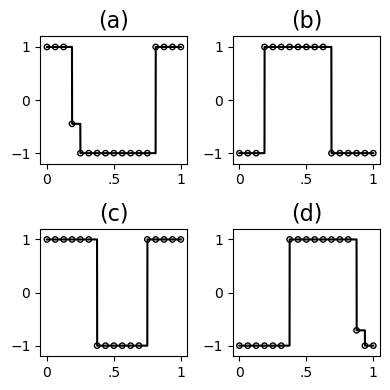

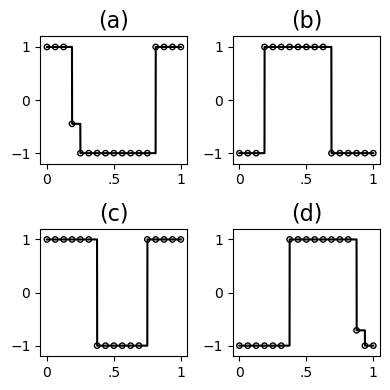

In [10]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0, 1, 1000), results=results, size=15)

In [62]:
Z = np.hstack((np.ones((runs,1)),results @ J_cb))
M = Z.T @ Z
np.linalg.det(M)

0.37832781772235596

## Comparissons with Literature

In [3]:
literature = np.array([
    [2, 2, 4, 8.750],
    [2, 3, 4, 8.828],
    [2, 4, 4, 8.750],
    [2, 8, 4, 8.493],
    [2, 16, 4, 8.427],
    [2, 100, 4, 8.404],
    [2, 2, 8, 3.958],
    [2, 3, 8, 4.287],
    [2, 4, 8, 3.903],
    [2, 8, 8, 3.902],
    [2, 16, 8, 3.887],
    [2, 100, 8, 3.882],
    [2, 2, 12, 2.583],
    [2, 3, 12, 2.778],
    [2, 4, 12, 2.570],
    [2, 8, 12, 2.539],
    [2, 16, 12, 2.520],
    [2, 100, 12, 2.512],
    [3, 3, 4, 386.408],
    [3, 4, 4, 246.869],
    [3, 8, 4, 218.479],
    [3, 16, 4, 208.843],
    [3, 100, 4, 206.884],
    [3, 3, 8, 189.766],
    [3, 4, 8, 103.553],
    [3, 8, 8, 99.109],
    [3, 16, 8, 97.408],
    [3, 100, 8, 96.709],
    [3, 3, 12, 126.409],
    [3, 4, 12, 67.735],
    [3, 8, 12, 65.217],
    [3, 16, 12, 63.610],
    [3, 100, 12, 63.028],

])

In [4]:
continuous_output_linear = []
for n_b in [2]:
    for run in [4,8,12]:
        for n_x in [2,3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_continuous(runs=run,
                                           f_list=[n_x],
                                           scalars=scalars,
                                           optimality=optimality,
                                           J_cb=J_cb,
                                           R_0=None,
                                           smooth_pen=0,
                                           ridge_pen=0,
                                           epochs=epochs,
                                           method=method,
                                           random_start=False,
                                           disable_bar=True,
                                           final_pass=True,
                                           final_pass_iter=200)
            continuous_output_linear.append(np.round(best_cr,3))

continuous_output_quadratic = []
for n_b in [3]:
    for run in [4,8,12]:
        for n_x in [3,4,8,16,100]:
            J_cb = calc_basis_matrix(x_basis=n_x, b_basis=n_b)
            _, best_cr = cordex_continuous(runs=run,
                                           f_list=[n_x],
                                           scalars=scalars,
                                           optimality=optimality,
                                           J_cb=J_cb,
                                           R_0=None,
                                           smooth_pen=0,
                                           ridge_pen=0,
                                           epochs=epochs,
                                           method=method,
                                           random_start=False,
                                           disable_bar=True,
                                           final_pass=True,
                                           final_pass_iter=200)
            continuous_output_quadratic.append(np.round(best_cr,3))

100%|██████████| 1000/1000 [00:16<00:00, 60.78it/s]


Executing final pass...


100%|██████████| 1000/1000 [00:24<00:00, 41.22it/s]


Executing final pass...


100%|██████████| 1000/1000 [00:33<00:00, 30.19it/s]


Executing final pass...


100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]


Executing final pass...


100%|██████████| 1000/1000 [02:14<00:00,  7.41it/s]


Executing final pass...


100%|██████████| 1000/1000 [11:50<00:00,  1.41it/s]


Executing final pass...


100%|██████████| 1000/1000 [00:30<00:00, 32.77it/s]


Executing final pass...


100%|██████████| 1000/1000 [00:46<00:00, 21.63it/s]


Executing final pass...


100%|██████████| 1000/1000 [01:02<00:00, 16.11it/s]


Executing final pass...


100%|██████████| 1000/1000 [02:11<00:00,  7.60it/s]


Executing final pass...


100%|██████████| 1000/1000 [04:07<00:00,  4.05it/s]


Executing final pass...


100%|██████████| 1000/1000 [19:26<00:00,  1.17s/it]


Executing final pass...


100%|██████████| 1000/1000 [00:48<00:00, 20.45it/s]


Executing final pass...


100%|██████████| 1000/1000 [01:26<00:00, 11.58it/s]


Executing final pass...


100%|██████████| 1000/1000 [01:59<00:00,  8.39it/s]


Executing final pass...


100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s]


Executing final pass...


100%|██████████| 1000/1000 [07:19<00:00,  2.28it/s]


Executing final pass...


100%|██████████| 1000/1000 [44:09<00:00,  2.65s/it]


Executing final pass...


100%|██████████| 1000/1000 [00:43<00:00, 22.97it/s]


Executing final pass...


100%|██████████| 1000/1000 [00:48<00:00, 20.54it/s]


Executing final pass...


100%|██████████| 1000/1000 [01:34<00:00, 10.55it/s]


Executing final pass...


100%|██████████| 1000/1000 [03:06<00:00,  5.35it/s]


Executing final pass...


100%|██████████| 1000/1000 [17:53<00:00,  1.07s/it]


Executing final pass...


100%|██████████| 1000/1000 [01:13<00:00, 13.60it/s]


Executing final pass...


100%|██████████| 1000/1000 [01:22<00:00, 12.06it/s]


Executing final pass...


100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


Executing final pass...


100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]


Executing final pass...


100%|██████████| 1000/1000 [31:10<00:00,  1.87s/it]


Executing final pass...


100%|██████████| 1000/1000 [01:44<00:00,  9.61it/s]


Executing final pass...


100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s]


Executing final pass...


100%|██████████| 1000/1000 [03:54<00:00,  4.26it/s]


Executing final pass...


100%|██████████| 1000/1000 [07:47<00:00,  2.14it/s]


Executing final pass...


100%|██████████| 1000/1000 [46:02<00:00,  2.76s/it] 


Executing final pass...


In [16]:
continuous_output = np.concatenate((continuous_output_linear, continuous_output_quadratic))
continuous_output

array([  8.75 ,   8.828,   8.75 ,   8.493,   8.429,   8.407,   3.958,
         4.287,   3.903,   3.902,   3.889,   3.883,   2.583,   2.778,
         2.57 ,   2.539,   2.52 ,   2.513, 386.538, 246.929, 219.118,
       210.642, 206.971, 189.766, 103.553,  99.109,  98.657,  97.51 ,
       126.409,  67.735,  65.226,  63.736,  63.033])

In [55]:
final_df = pd.DataFrame([])

In [56]:
final_df = np.hstack((literature, continuous_output.reshape(-1,1)))
# final_df[21, 4] = 208.843

In [57]:
diffs = np.round(np.abs(final_df[:,3] - final_df[:,4]),3)

In [58]:
final_df = np.hstack((final_df, diffs.reshape(-1,1)))
final_df

array([[2.00000e+00, 2.00000e+00, 4.00000e+00, 8.75000e+00, 8.75000e+00,
        0.00000e+00],
       [2.00000e+00, 3.00000e+00, 4.00000e+00, 8.82800e+00, 8.82800e+00,
        0.00000e+00],
       [2.00000e+00, 4.00000e+00, 4.00000e+00, 8.75000e+00, 8.75000e+00,
        0.00000e+00],
       [2.00000e+00, 8.00000e+00, 4.00000e+00, 8.49300e+00, 8.49300e+00,
        0.00000e+00],
       [2.00000e+00, 1.60000e+01, 4.00000e+00, 8.42700e+00, 8.42900e+00,
        2.00000e-03],
       [2.00000e+00, 1.00000e+02, 4.00000e+00, 8.40400e+00, 8.40700e+00,
        3.00000e-03],
       [2.00000e+00, 2.00000e+00, 8.00000e+00, 3.95800e+00, 3.95800e+00,
        0.00000e+00],
       [2.00000e+00, 3.00000e+00, 8.00000e+00, 4.28700e+00, 4.28700e+00,
        0.00000e+00],
       [2.00000e+00, 4.00000e+00, 8.00000e+00, 3.90300e+00, 3.90300e+00,
        0.00000e+00],
       [2.00000e+00, 8.00000e+00, 8.00000e+00, 3.90200e+00, 3.90200e+00,
        0.00000e+00],
       [2.00000e+00, 1.60000e+01, 8.00000e+00, 3.8

In [59]:
Final_df = pd.DataFrame(final_df)
Final_df.columns = ['n_b', 'n_x', 'runs', 'Literature', 'Continuous', 'Difference']

In [61]:
Final_df

,n_b,n_x,runs,Literature,Continuous,Difference
0,2.0,2.0,4.0,8.750,8.750,0.000
1,2.0,3.0,4.0,8.828,8.828,0.000
2,2.0,4.0,4.0,8.750,8.750,0.000
3,2.0,8.0,4.0,8.493,8.493,0.000
4,2.0,16.0,4.0,8.427,8.429,0.002
5,2.0,100.0,4.0,8.404,8.407,0.003
6,2.0,2.0,8.0,3.958,3.958,0.000
7,2.0,3.0,8.0,4.287,4.287,0.000
8,2.0,4.0,8.0,3.903,3.903,0.000
9,2.0,8.0,8.0,3.902,3.902,0.000


In [62]:
Final_df.to_csv('Comparisson.csv')